# Max-SAT: LP Rounding versus CP-SAT

# Implementation

## Setup
We start off with the same basic setup for SAT, a lot of it copy and pasted from PennSAT

In [1]:
# Optional[A] means either type A or None
# Union[A, B] means either type A or type B
from typing import Union, Optional, List, Tuple
Lit = int
Var = int
Clause = List[Lit]
CNF = List[Clause]
# A (partial) assignment is an array storing True/False/None for each variable
Assignment = List[Optional[bool]]

In [2]:
from random import shuffle, randint
import numpy as np

# random k-CNFs with n variables and m clauses
def F(k: int, n: int, m: int) -> CNF:
    # Fill in here
    vars = [i + 1 for i in range(n)]
    cnf = []
    for _ in range(m):
        shuffle(vars)
        # coin flip (-1 or 1)
        flips = [randint(0, 1) * 2 - 1 for _ in range(k)]
        cnf.append(list(np.multiply(vars[:k], flips)))
    return cnf

In [3]:
# takes in a CNF and a list of assignments
# and outputs the number of satisfied
def count_sat(CNF, asses):
    def check_lit(lit):
        var = abs(lit)
        sign = lit // var 
        return asses[var] == sign
    def clause_sated(clause):
        filtered = list(filter(check_lit, clause))
        return len(filtered) > 0
    sated = list(filter(clause_sated, CNF))
    return len(sated)

### LP rounding
Helper stuff out of the way, we'll start off with the LP rounding solution. `solveLP` performs the LP algorithm, while `johnson` and `lp_rounding` implement the two rounding schemes. Finally, `do_lp_algo` puts the two parts together to approximate the solution.

In [4]:
# LP implementation
from ortools.linear_solver import pywraplp

# takes in a k-CNF, with n variables and m clauses
# returns a DECIMAL solution
def solveLP(CNF, k, n, m):
    solver = pywraplp.Solver("lp", pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    zs = [solver.NumVar(0, 1, f'z_{j}') for j in range(m)] # variable for if the j-th clause is satisfied
    ys = [solver.NumVar(0, 1, f'y_{i}') for i in range(n+1)] # variable for if the i-th clause is set to True
    # add constraints
    for j in range(m):
        clause = CNF[j]
        # count number of negatives
        neg_count = sum(1 for lit in clause if lit < 0)
        constraint = solver.Constraint(-neg_count, solver.infinity()) # must be larger than z_j
        constraint.SetCoefficient(zs[j], -1)
        for lit in clause:
            var = abs(lit)
            sign = lit / var
            constraint.SetCoefficient(ys[var], sign)
    # maximize number of satisfied clauses
    objective = solver.Objective()
    for zj in zs:
        objective.SetCoefficient(zj, 1)
    objective.SetMaximization()
    solver.Solve()
    def get_sols(xs):
        return list(map(lambda x : x.solution_value(), xs))
    return (get_sols(ys), get_sols(zs))
    return solver

In [5]:
# now, we do the rounding
from random import choices

# Johnson's rounding scheme: set each var with probability 1/2
def johnson(n):
    return [randint(0, 1) * 2 - 1 for _ in range(n + 1)]

# LP rounding scheme
def lp_rounding(CNF, ys):
    return [choices([1, -1], cum_weights=[ys[i], 1]) for i in range(len(ys))]

# solve the LP, do both rounding schemes
# output (Best, Johnson, LP)
def do_lp_algo(CNF, k, n, m):
    ys, zs = solveLP(CNF, k, n, m)

    ass1 = johnson(n)
    ass2 = lp_rounding(CNF, ys)
    # print(ass1)

    count1 = count_sat(CNF, ass1)
    count2 = count_sat(CNF, ass2)

    best = max(count1, count2)
    # for documentation purposes
    better = "Johnson" if count1 < count2 else ("LP" if count1 > count2 else "Equal")


    return (best, better)

# Question: what is the expected number of satisfied clauses in a CNF formula?

## ILP Solution
Now, we'll do the ILP algorithm. This is essentially the same as the LP rounding model, except now we use CP-SAT rather than Glop

In [6]:
# ILP version
from ortools.sat.python import cp_model

def solveILP(CNF, k, n, m, time_lim=None, allow_feasible=False):
    model = cp_model.CpModel()
    zs = [model.NewIntVar(0, 1, f'z_{j}') for j in range(m)] # variable for if the j-th clause is satisfied
    ys = [model.NewIntVar(0, 1, f'y_{i}') for i in range(n+1)] # variable for if the i-th clause is set to True
    # add constraints
    for j in range(m):
        clause = CNF[j]
        lhs = 0
        # add up variable values
        for lit in clause:
            var = abs(lit)
            sign = lit / var
            if sign == 1:
                lhs += ys[var]
            else:
                lhs += 1 - ys[var]
        # ensure that it's larger than z_j
        model.Add(lhs >= zs[j])
    # maximize number of satisfied clauses
    model.Maximize(sum(zs))

    solver = cp_model.CpSolver()
    if time_lim is not None:
        solver.parameters.max_time_in_seconds = time_lim
    status = solver.Solve(model)
    if status == cp_model.OPTIMAL or (status == cp_model.FEASIBLE and allow_feasible):
      def get_sols(xs):
          return list(map(lambda x : solver.Value(x), xs))
      return (get_sols(ys), get_sols(zs))
    else:
      return (None, None)

def do_ilp_algo(CNF, k, n, m, time_lim=None, allow_feasible=False):
    _, zs = solveILP(CNF, k, n, m, time_lim, allow_feasible)
    if zs is None:
      return None
    return sum(zs)

# Testing
The goal of this section is to see how the LP and ILP algorithms compare. We run two rounds of testing:

1. Run LP and ILP to termination (so ILP is guaranteed optimal). The goal of this case is to see how well LP does compared to optimal. Note that we do still set a time cutoff, but in the cases that are cut off, we throw out that data point rather than using the feasible but non-optimal ILP solution.

2. Cut off ILP at 1.5 * LP runtime. This ensures that ILP must run for a time on the order of LP runtime. Thus, we expect that ILP will often be cut off. In this case, we don't throw out the result. We compare the non-optimal ILP solution with the LP approximation.

In each round, we keep track of LP and ILP running times, approximation errors, and what percent of the time Johnson gives us the best rounding solution.

In [7]:
from timeit import default_timer as timer

# runs a function, and returns the result and the time it took
def timeFctn(func):
    t = timer()
    res = func()
    return (res, timer() - t)

## Round 1 

In [8]:
# 2d array of n's and m's
# m from 40 to 1000, n from 6 through 30
nms1 = [[(n * 3, m) for n in range(2, min(10, m // 4))] for m in range(40, 740, 50)]

In [9]:
from functools import partial

def run_trial_type_1(k):
  p = len(nms1)
  q = min(map(lambda arr: len(arr), nms1))

  # things we're keeping track of
  ilp_times1 = []
  lp_times1 = []
  errors1 = []
  # number of times we use Johnson rounding vs LP rounding
  johnsonCount1 = 0
  lpCount1 = 0

  # samples per (n, m) pair
  sample_size = 3
  # time cutoff for each run
  time_lim = 1
  for arr in nms1:
      it = []
      lt = []
      er = []
      for (n, m) in arr:
          tot_error = 0
          tot_ilp_t = 0
          tot_lp_t = 0
          done = False
          # run multiple trials
          for s in range(sample_size):
              ex = F(k, n, m)
              # do_lp_algo(ex, k, n, m)
              # do LP
              (resLP, timeLP) = timeFctn(partial(do_lp_algo, ex, k, n, m))
              (bestLP, choice) = resLP

              if choice == "Johnson":
                johnsonCount1 += 1
              else:
                lpCount1 += 1

              # do ILP
              (resILP, timeILP) = timeFctn(partial(do_ilp_algo, ex, k, n, m, time_lim=time_lim))
              # if timed out then stop here
              if resILP is None:
                  done = True
                  break
              tot_error += 1 - (bestLP / resILP)
              tot_ilp_t += timeILP
              tot_lp_t += timeLP
          if done is True:
              break
          it.append(tot_ilp_t / sample_size)
          lt.append(tot_lp_t / sample_size)
          er.append(tot_error / sample_size)
          # print(f'Finished {n}, {m}')
      ilp_times1.append(it)
      lp_times1.append(lt)
      errors1.append(er)
  return ilp_times1, lp_times1, errors1, (johnsonCount1 / (johnsonCount1 + lpCount1))

ilp_times1, lp_times1, errors1, johnsonRatio1 = run_trial_type_1(3)

In [10]:
import matplotlib.pyplot as plt

In [11]:
# helper to convert data into plottable data
def to_scatterable(X, Y):
  xs = []
  ys = []
  zs = []

  for i in range(min(len(X), len(Y))):
    Xi = X[i]
    Yi = Y[i]

    for j in range(min(len(Xi), len(Yi))):
      (x, y) = Xi[j]
      z = Yi[j]

      xs.append(x)
      ys.append(y)
      zs.append(z)
  return (xs, ys, zs)

# plot data against n, m pairs
def myplot(nms, data):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  (xs, ys, zs) = to_scatterable(nms, data)
  ax.scatter(xs, ys, zs)
  plt.show()

### LP runtime
The below plot show the runtime of the LP algorithm plotted against n and m. Surprisingly, it looks like the runtime does not depend on n whatsoever, and only depends linearly on m. This makes it seem like it would be very practical even for large formulae.

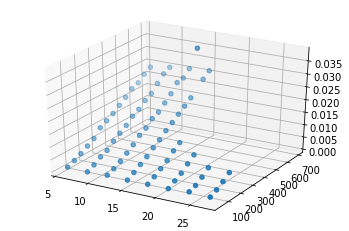

In [12]:
myplot(nms1, lp_times1)

### ILP runtime
In contrast, the ILP algorithm looks to be exponential in both n and m. For n around 25, it can even handle any formulae with more than 200 clauses without taking more than 1 second (that's why it's cut off there).

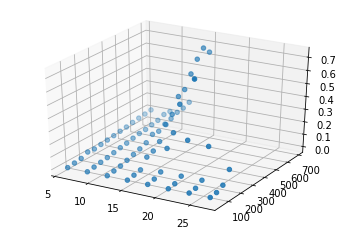

In [13]:
myplot(nms1, ilp_times1)

### Optimality
The below graph shows the approximation error of the LP algorithm versus optimal. There seems to be very little correlation with n and m.

What's surprising is that the average approximation error was less than 1/20. While the theoretical best that any algorithm should be able to do on 3-CNFs (unless P=NP) is expected 1/8 error. This suggests that LP rounding may perform better in practice than its theoretical bounds.

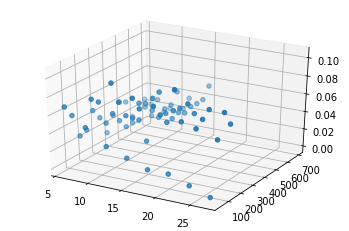

In [14]:
myplot(nms1, errors1)

In [15]:
import numpy as np

def get_mean_var(errors):
  err_flat = [err for sublist in errors for err in sublist]
  n = len(err_flat)
  # stats
  mean = sum(err_flat)/n
  var = sum([(x - mean)**2 for x in err_flat])/n
  return mean, var

In [16]:
get_mean_var(errors1)

(0.0474861732157844, 0.0005044821908618398)

In [17]:
johnsonRatio1

0.6329113924050633

## Round 2

In [18]:
from functools import partial
# harder test cases: m from 500 to 2000; n from 10 to 200
nms2 = [[(n * 10, m) for n in range(1, min(20, m // 4))] for m in range(500, 2000, 200)]

def run_trial_type_2(k):
  ilp_times2 = []
  lp_times2 = []
  errors2 = []
  johnsonCount2 = 0
  lpCount2 = 0
  sample_size = 3
  # we now constrain ILP to run in time_factor * timeLP
  time_factor = 1.5
  for arr in nms2:
      it = []
      lt = []
      er = []
      for (n, m) in arr:
          tot_error = 0
          tot_ilp_t = 0
          tot_lp_t = 0
          done = False
          count = 0
          # run multiple trials
          for s in range(sample_size):
              ex = F(k, n, m)
              # do_lp_algo(ex, k, n, m)
              (resLP, timeLP) = timeFctn(partial(do_lp_algo, ex, k, n, m))
              (bestLP, choice) = resLP # TODO: take into account the two different rounders

              if choice == "Johnson":
                johnsonCount2 += 1
              else:
                lpCount2 += 1

              (resILP, timeILP) = timeFctn(partial(do_ilp_algo, ex, k, n, m, time_lim=timeLP * time_factor, allow_feasible=True))

              # despite allowing feasible, ILP 
              # sometimes still returns None
              if resILP is None:
                  continue
              tot_error += 1 - (bestLP / resILP)
              tot_ilp_t += timeILP
              tot_lp_t += timeLP
              count += 1
          if count == 0:
            break
          it.append(tot_ilp_t / count)
          lt.append(tot_lp_t / count)
          er.append(tot_error / count)
      ilp_times2.append(it)
      lp_times2.append(lt)
      errors2.append(er)
  return ilp_times2, lp_times2, errors2, (johnsonCount2 / (johnsonCount2 + lpCount2))

ilp_times2, lp_times2, errors2, johnsonRatio2 = run_trial_type_2(3)

### LP runtime
Once again, the LP algorithm looks to have minimal dependence on n, and only linear dependence on m. Even with formula with 200 variables as long as 2000 clauses, the runtime stays under 0.15 of a second.

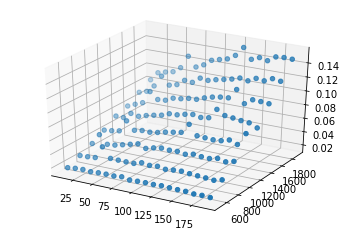

In [19]:
myplot(nms2, lp_times2)

### Optimality
It seems that, despite the levelling of the playing field with a time constraint, the ILP algorithm still holds its own. It still does consistently better than LP even though it is only outputting feasible, rather than optimal, solutions.

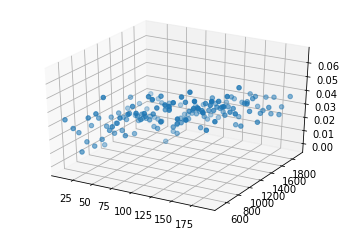

In [33]:
myplot(nms2, errors2)

In [21]:
get_mean_var(errors2)

(0.031102778965286067, 0.00021937955783450807)

In [22]:
johnsonRatio2

0.7083333333333334

## Round 3
JK I was lying, there's too more rounds to go. We rerun the above two trial types, but now with k=5

I expect that LP rounding will do much better in this case since even just randomly tossing a coin for variable assignments gives expected 31/32 of the optimal solution.

In [23]:
ilp_times3, lp_times3, errors3, johnsonRatio3 = run_trial_type_1(5)

### Runtimes
Once again, LP is linear in m, while ILP is exponential. However, it seems like ILP does better with larger k, perhaps because it is easier to find a satisfying solution.

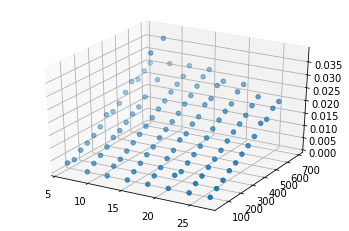

In [24]:
myplot(nms1, lp_times3)

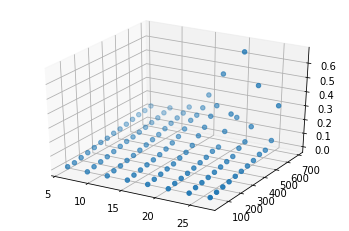

In [25]:
myplot(nms1, ilp_times3)

### Optimality
What's really nice here is that we get really good approximaton error. As in better than 1/50. This was just as we'd predicted.

The Johnson ratio seemed not to have changed, staying at around 60%. This was somewhat different from what I was expecting, since I Johnson should do really well now due to large k. This suggests that LP rounding also does better with large k, keeping pace with Johnson.

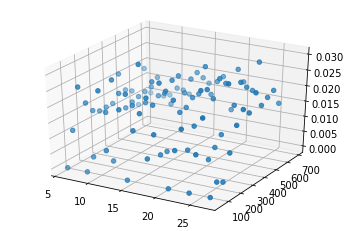

In [26]:
myplot(nms1, errors3)

In [27]:
get_mean_var(errors3)

(0.01633779949419267, 5.033707082751893e-05)

In [28]:
johnsonRatio3

0.6375

## Round 4

In [29]:
ilp_times4, lp_times4, errors4, johnsonRatio4 = run_trial_type_2(5)

### Optimality
As expected, once again, our error here is even lower than before, with an approximation error LP versus ILP of around 1/100.

Interestingly, when I ran this (twice), the Johnson ratio was more than 80% both times. Not sure what to make of that, given that the other runs were all pretty consistent around 60%. 

Also, this is the first time seeing the LP algorithm actually do better than ILP in some cases (namely with high n and relatively low m). This suggests that there may indeed be some cases (perhaps with higher k, and higher n) where LP will do consistently better than a cut-off ILP.

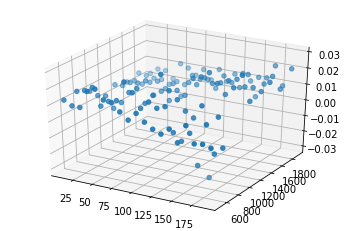

In [30]:
myplot(nms2, errors4)

In [31]:
get_mean_var(errors4)

(0.009756840218850631, 5.8636191553397085e-05)

In [32]:
johnsonRatio4

0.8696741854636592

# Concluding thoughts

Overall, this was an informative exercise. 

A couple things surprised us. We were surprised by how good the runtime performance of the LP algorithm was, as well as its performance versus optimal. We were also surprised by how well the ILP algorithm performed despite being cut off well shy of what it would take to find an optimal solution.

But just to be clear, we weren't completely clueless; we did predict some things correctly. As we expected, increasing k made the LP algorithm perform better. Also, cutting off ILP at a constant times the LP running time did level the playing field somewhat; just not as much as we would have expected.

We therefore come to two main conclusions. 1: LP does really well on MaxSAT, even better than theory would predict. 2: But ILP does even better; even if you cap it at linear running time.
